In [1]:
# ! pip install --quiet gensim

In [30]:
import pandas as pd
import re
yelps = pd.read_csv('sentiment/yelps.csv')
yelps = yelps.sample(frac=1)

In [31]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    
    return re.findall(r"\b\w\w+\b",s)
    


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD


# 1. The original TF matrix
feature_extractor = CountVectorizer (preprocessor= clean_yelp, tokenizer= tokenize)

term_freq_matrix = feature_extractor.fit_transform(yelps.text)

# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

svd_processor = TruncatedSVD (n_components= 100)

matrix_svd = svd_processor.fit_transform(term_freq_matrix)

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

/home/lucas/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/lucas/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver='lbfgs', max_iter= 1000)
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [36]:

scores_tf = []
scores_te = []

rounds = 5

cutofs_seq = list(range(1000,len(yelps.positive),int(len(yelps.positive)/rounds))) 


for c in cutofs_seq:
    a = test_holdout_vectors(term_freq_matrix, yelps.positive, c)
    scores_tf.append(a)
    b = test_holdout_vectors(matrix_svd, yelps.positive, c)
    scores_te.append(b)
    
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

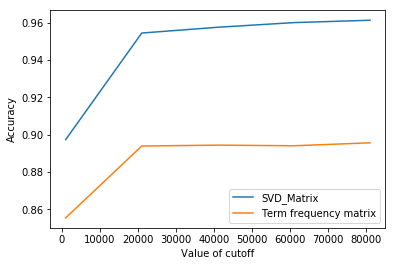

In [42]:
import matplotlib.pyplot as plt
# Plotting
plt.plot(cutofs_seq,scores_tf)
plt.plot(cutofs_seq,scores_te)
plt.xlabel("Value of cutoff")
plt.ylabel("Accuracy")
plt.legend(["SVD_Matrix","Term frequency matrix"])

In [49]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

In [50]:
sentences = []

for sentence in yelps.text:
     sentences.append(tokenize(clean_yelp(sentence)))

/home/lucas/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/lucas/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [51]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [53]:
model = Word2Vec(sentences = sentences, 
                 workers=8, 
                 min_count = 5,
                 size=100, 
                 window=5, 
                 sg = 2)

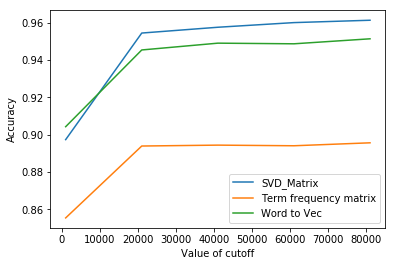

In [56]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a
# use as follows: np.array([embed_w2v(t, w2v) for t in X])
# Embedding yelps reviews as normalized sum of word embedding vectors

w2v_embed = np.array([embed_w2v(t, model) for t in sentences])

# Obtain accuracy 

scores_w2v = []
for c in cutofs_seq:
    a = test_holdout_vectors(w2v_embed, yelps.positive, c)
    scores_w2v.append(a)

# Plotting
plt.plot(cutofs_seq,scores_tf)
plt.plot(cutofs_seq,scores_te)
plt.plot(cutofs_seq,scores_w2v)
plt.xlabel("Value of cutoff")
plt.ylabel("Accuracy")
plt.legend(["SVD_Matrix","Term frequency matrix", "Word to Vec"])


In [67]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(sub, pats, s)
    s = ' '.join(s.split()).strip()

 
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [68]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('./tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [69]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [70]:

# 1. The original TF matrix
feature_extractor = CountVectorizer (preprocessor= clean_twitter, tokenizer= tokenize)

term_freq_matrix = feature_extractor.fit_transform(tweets)

# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

svd_processor = TruncatedSVD (n_components= 100)

matrix_svd = svd_processor.fit_transform(term_freq_matrix)

sentences = []

for sentence in tweets:
     sentences.append(tokenize(clean_twitter(sentence)))
        
model = Word2Vec(sentences = sentences, 
                 workers=8, 
                 min_count = 5,
                 size=100, 
                 window=5, 
                 sg = 2)

In [72]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

In [75]:

display(model.wv.most_similar('trump'))
display(model.wv.most_similar('hillary'))
display(model.wv.most_similar(positive=['trump'], negative=['hillary']))

/home/lucas/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.8212153315544128),
 ('trumps', 0.764931321144104),
 ('trum', 0.7363682985305786),
 ('tusk', 0.7017428278923035),
 ('peña', 0.6940112113952637),
 ('railing', 0.6892824172973633),
 ('resounding', 0.6840604543685913),
 ('amnestydon', 0.6777538061141968),
 ('gopers', 0.6771611571311951),
 ('broadens', 0.6763956546783447)]

[('clinton', 0.858627438545227),
 ('hilary', 0.8494096994400024),
 ('crooked', 0.834505558013916),
 ('hiliary', 0.7974550724029541),
 ('hilliary', 0.7956953048706055),
 ('killary', 0.7717493772506714),
 ('hrc', 0.7706645727157593),
 ('rodham', 0.7704799771308899),
 ('4dead', 0.7646650075912476),
 ('wallst', 0.7601121664047241)]

[('trumps', 0.38153713941574097),
 ('nobannowall', 0.3433765172958374),
 ('coachella', 0.34305334091186523),
 ('slovenia', 0.3335583209991455),
 ('mar', 0.3320533335208893),
 ('cpac', 0.33136558532714844),
 ('presidenttrump', 0.3181767463684082),
 ('istandwithtrump', 0.3148789405822754),
 ('singapore', 0.31364116072654724),
 ('trumpkimsummit', 0.31224125623703003)]

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data

/home/lucas/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/lucas/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


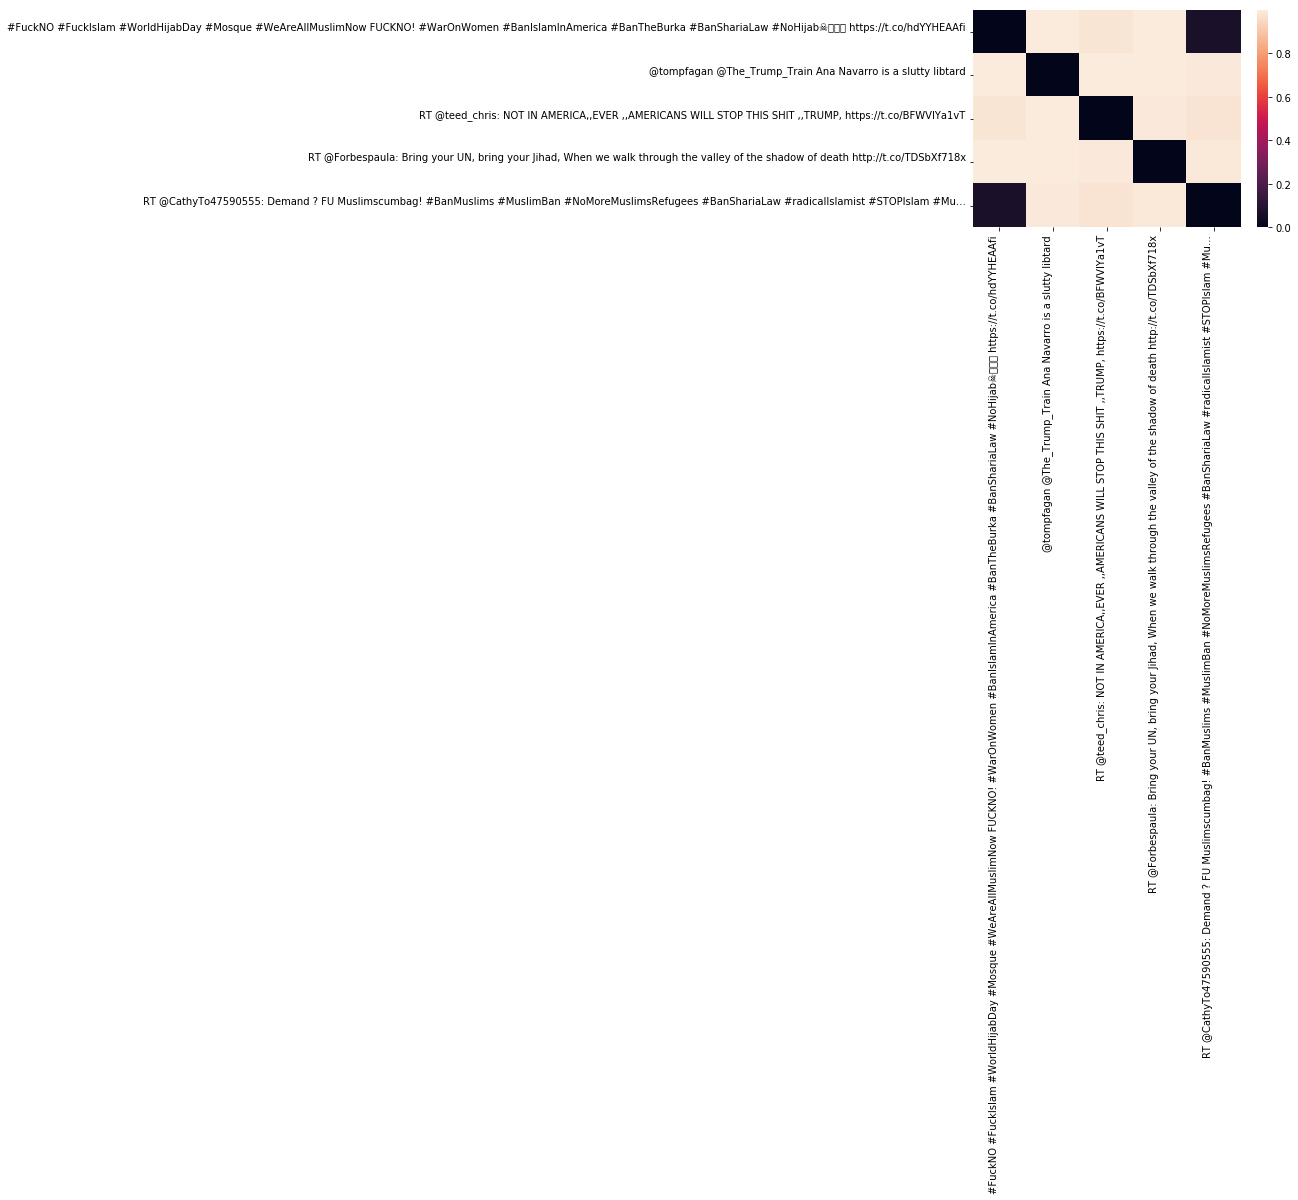

In [79]:
visualize_dist(matrix_svd, tweets, idxs = np.random.randint(0, high = len(tweets), size = 5) # creating random indexes
)
